In [2]:
import numpy as np
import os
import skimage as sk
import skimage.io as skio
from skimage.util import img_as_ubyte
from helper import *
import cv2

In [133]:
def ncc(img1, img2, eps: float = 1e-12):
    """Compute the normalized cross-correlation between two images."""
    # Normalize each vector
    image1_flat = img1.ravel()
    image2_flat = img2.ravel()
    norm1 = image1_flat
    norm2 = image2_flat
    denoms = np.linalg.norm(norm1) * np.linalg.norm(norm2)

    return np.dot(norm1, norm2) / denoms

def l2_norm(img1, img2):
    """Compute the L2 norm between two images."""
    return -np.linalg.norm(img2 - img1)

In [134]:
def overlap_views(img1, img2, dy, dx):
    """Return two cropped views (no wrap) that overlap when img2 is shifted by (dy, dx)."""
    H, W = img1.shape
    y0 = max(0,  dy); y1 = min(H, H + dy)
    x0 = max(0,  dx); x1 = min(W, W + dx)
    # Corresponding regions in img1 and shifted img2
    v1 = img1[y0:y1, x0:x1]
    v2 = img2[y0-dy:y1-dy, x0-dx:x1-dx]
    return v1, v2

def cal_metric(metric_func, img1, img2, dy, dx):
    
    im1, im2 = overlap_views(img1, img2, dy, dx)
    return metric_func(im1, im2)

In [132]:
# for simple jpg image alignment
def align_index(window, img1, img2, metric_func=l2_norm):
    img1 = img1[20:img1.shape[0]-20, 20:img1.shape[1]-20]
    img2 = img2[20:img2.shape[0]-20, 20:img2.shape[1]-20]
    
    win_h, win_w = window[0], window[1]
    min_metric= float('-inf')
    best_h, best_w = 0, 0
    for h in range(-win_h, win_h+1):
        for w in range(-win_w, win_w+1):
            img2_shift = np.roll(img2, shift=(h, w), axis=(0, 1))
            # compute the distance between the two images
            # metric = cal_metric(metric_func, img1, img2_shift, dy=h, dx=w)
            metric = metric_func(img1, img2_shift)
            if metric > min_metric:
                min_metric = metric
                best_h = h
                best_w = w
    # align_img = np.roll(img2, shift=(best_h, best_w), axis=(0, 1))
    return best_h, best_w

def align(window, img1, img2, metric_func=l2_norm):
    best_h, best_w = align_index(window, img1, img2, metric_func=metric_func)
    print(best_h, best_w)
    align_img = np.roll(img2, shift=(best_h, best_w), axis=(0, 1))
    return align_img

In [131]:
def align_img(img_path):
    # name of the input file
    imname = img_path

    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im).astype(np.float32)
        
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    ag = align((20, 20), b, g, metric_func=ncc)
    ar = align((20, 20), b, r, metric_func=ncc)
    im_out = np.dstack([ar, ag, b])

    skio.imshow(im_out)
    skio.show()

    filename, ext = os.path.splitext(os.path.basename(imname))
    fname = f'./output/{filename}_align_naive.jpg'
    skio.imsave(fname, img_as_ubyte(im_out))

5 2
12 3


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:23: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:24: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


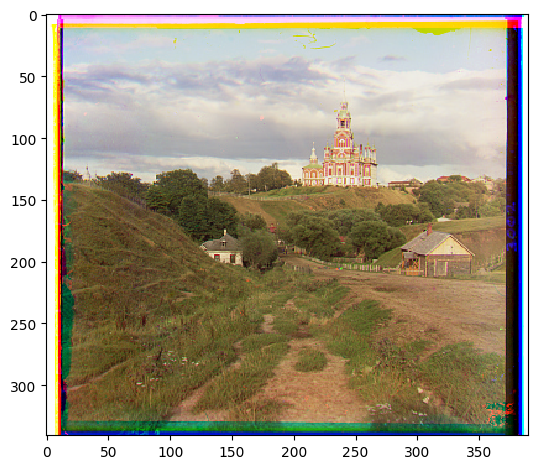

-3 2
3 2


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:23: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:24: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


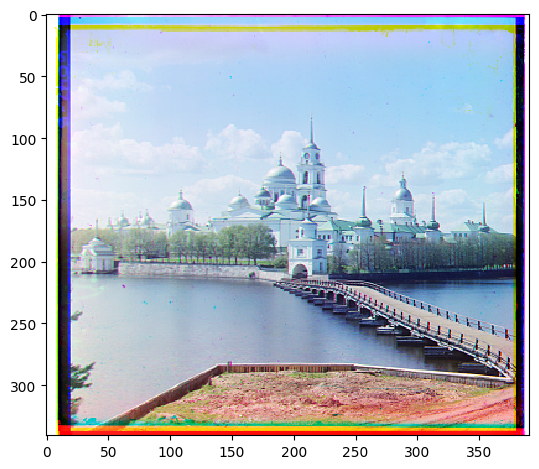

3 3
6 3


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:23: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1489/3723370488.py:24: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


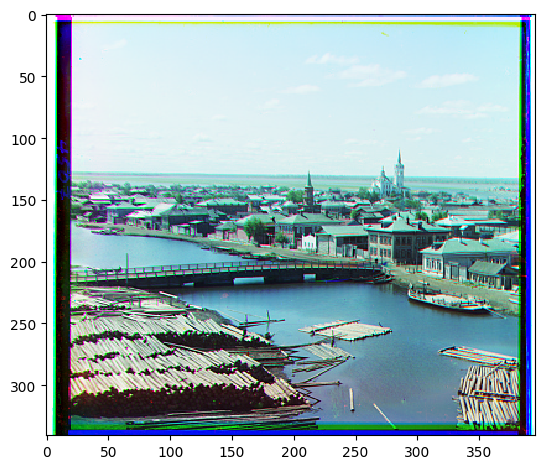

In [135]:
img_list = [
    'proj1_data/cathedral.jpg',
    'proj1_data/monastery.jpg',
    'proj1_data/tobolsk.jpg'
]
for img in img_list:
    align_img(img)